### Import libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import xgboost
sns.set(style="white", context="talk")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats

from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix,precision_recall_curve, roc_curve

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Load dataset

In [2]:
df=pd.read_csv('datasets/raw_data.csv')

In [3]:
df.head()

,Unnamed: 0,city,churn,type_of_plan,highest_level_education,work_status,sex,relationship_status,payment_per_month,weeks_since_claim,open_policies,Renew_Offer_Type,reachability,type_of_vehicle
0,0,Tamale,No,primary_plan,Bachelor,Employed,female,Married,138,138,1,1,contacting_agent,2-door_car
1,1,Takoradi,No,extended_plan,Bachelor,Unemployed,female,Single,188,56,8,3,contacting_agent,4-door_car
2,2,Cape_coast,No,premium_plan,Bachelor,Employed,female,Married,216,77,2,1,contacting_agent,2-door_car
3,3,Accra,No,primary_plan,Bachelor,Unemployed,male,Married,212,77,7,1,customer_call_centre,SUV
4,4,Tamale,No,primary_plan,Bachelor,Employed,male,Single,146,52,1,1,contacting_agent,4-door_car


In [4]:
df=df.drop(columns=['Unnamed: 0'])

In [5]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")
print('Are there any missing values?',df.isnull().sum().any())

There are 9134 rows and 13 columns
Are there any missing values? False


#### There is a big standard deviation in the columns, except the renew offer type, which is basically a categorical column, which signifies the values of these columns are far apart and spread out from the mean, which normally indicates outliers, but would leave it for now

In [6]:
df['Renew_Offer_Type']=df['Renew_Offer_Type'].astype('object')

In [7]:
df.describe()

,payment_per_month,weeks_since_claim,open_policies
count,9134.000000,9134.000000,9134.000000
mean,186.438581,64.923035,2.966170
std,68.815935,43.293372,2.390182
min,122.000000,0.000000,1.000000
25%,136.000000,26.000000,1.000000
50%,166.000000,60.000000,2.000000
75%,218.000000,99.000000,4.000000
max,596.000000,150.000000,9.000000


### Univariate and bivariate visualizations and analysis

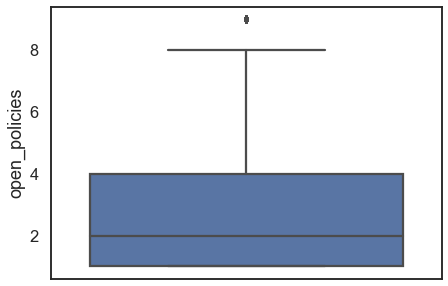

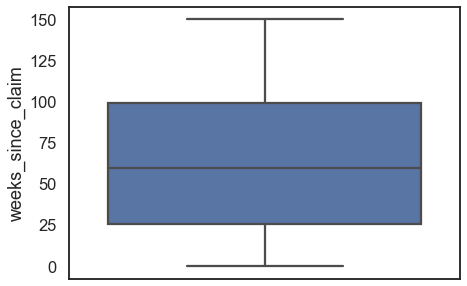

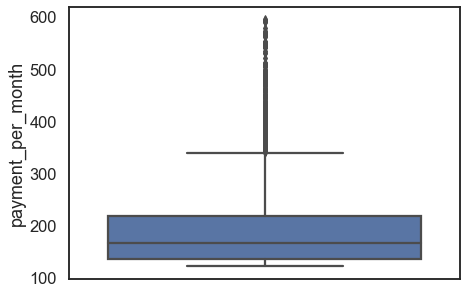

In [8]:
plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.boxplot(y=df['open_policies'],data=df)

plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.boxplot(y=df['weeks_since_claim'],data=df)

plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.boxplot(y=df['payment_per_month'],data=df);

#### This boxplot gives further proof of the number of outliers present

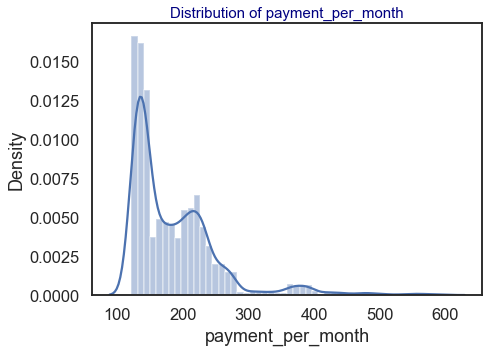

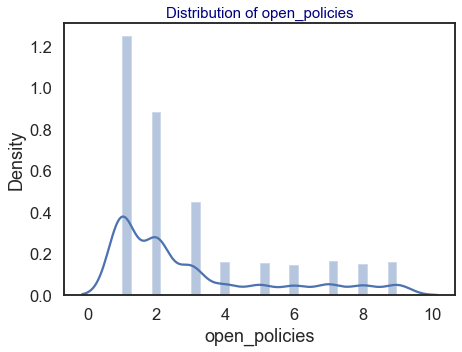

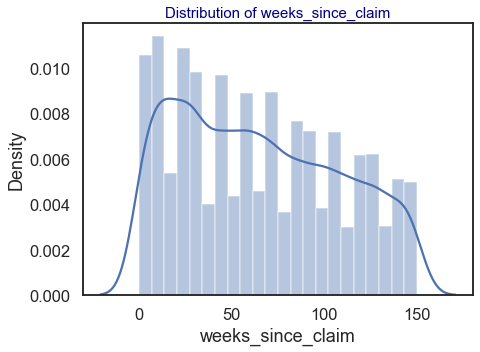

In [9]:
plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.distplot(df['payment_per_month'])
plt.title('Distribution of payment_per_month', color='navy', fontsize=15);

plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.distplot(df['open_policies'])
plt.title('Distribution of open_policies', color='navy', fontsize=15)

plt.figure(figsize=(7,17))
plt.subplot(3,1,1)
sns.distplot(df['weeks_since_claim'])
plt.title('Distribution of weeks_since_claim', color='navy', fontsize=15);

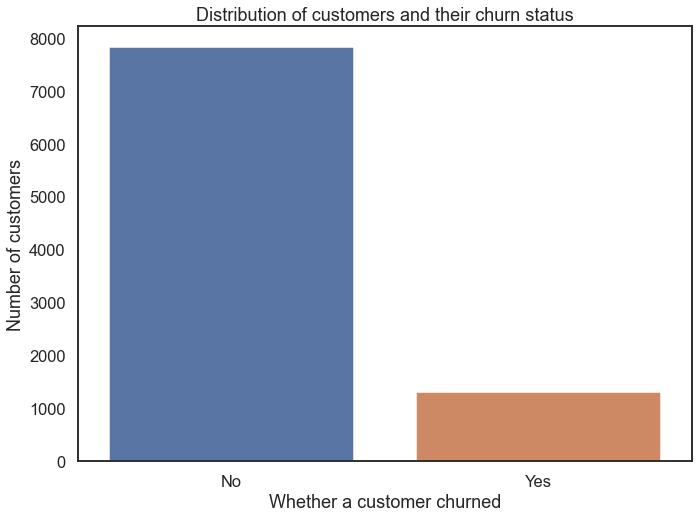

In [10]:
plt.figure(figsize=(11,8))
sns.countplot(x='churn', data=df)
plt.xlabel('Whether a customer churned')
plt.ylabel('Number of customers')
plt.title('Distribution of customers and their churn status');

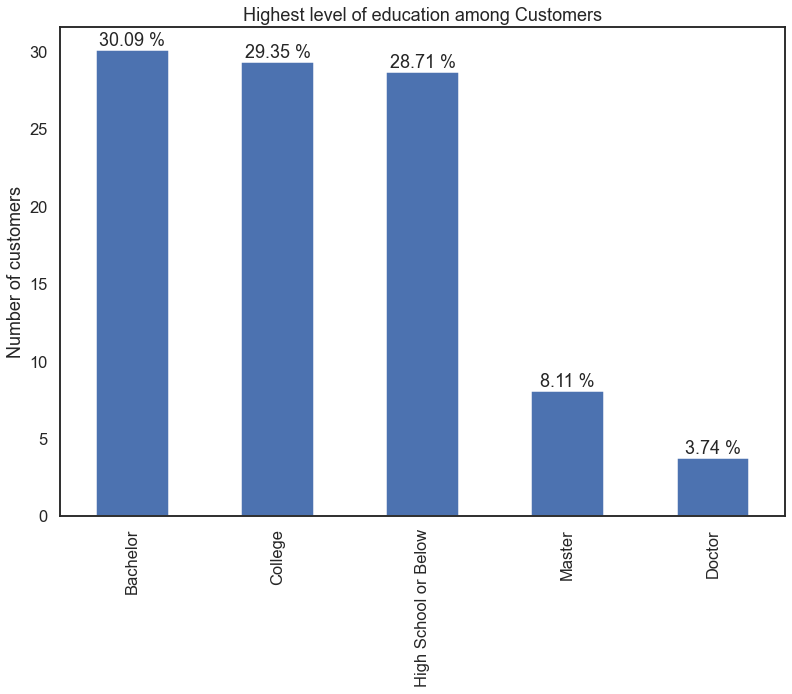

In [11]:
plt.figure(figsize=(13,9))
ax = (df['highest_level_education'].value_counts()/len(df['highest_level_education'])*100).plot.bar(rot=90)
ax.bar_label(ax.containers[0], fmt='%.2f %%')
ax.margins(x=12)
plt.ylabel('Number of customers')
plt.title('Highest level of education among Customers')
plt.show()



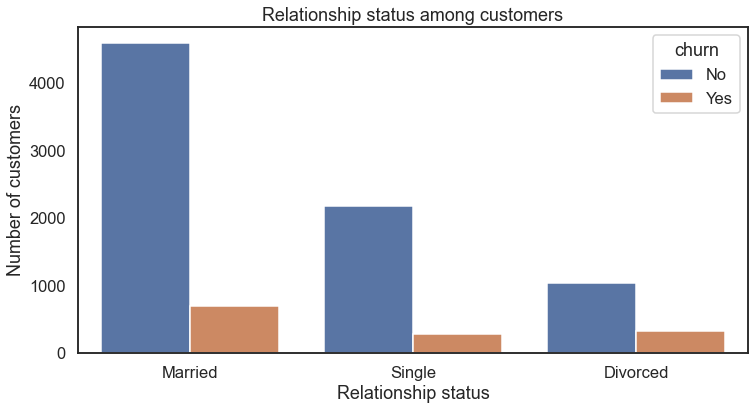

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='relationship_status', data=df,hue='churn')
plt.xlabel('Relationship status')
plt.ylabel('Number of customers')
plt.title('Relationship status among customers');

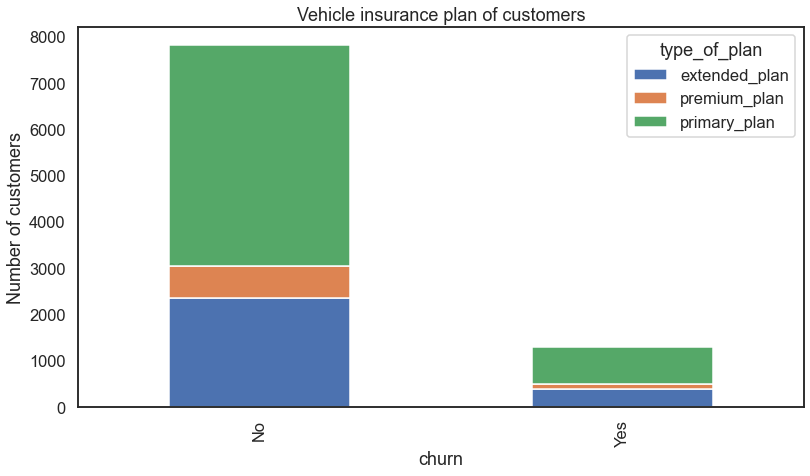

In [13]:
df_plot = df.groupby(['type_of_plan','churn']).size().reset_index().pivot(columns='type_of_plan', index='churn', values=0)
df_plot.plot(kind='bar', stacked=True,figsize=(13,7))
plt.ylabel('Number of customers')
plt.title('Vehicle insurance plan of customers');

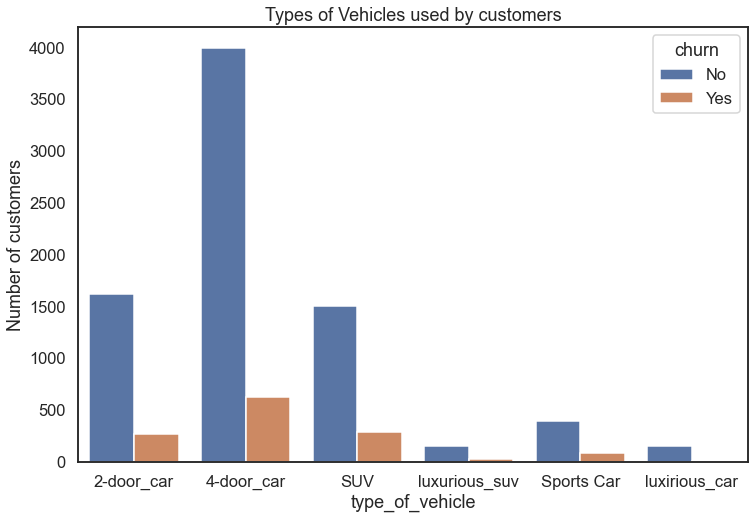

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x='type_of_vehicle', data=df,hue='churn')
plt.xlabel('type_of_vehicle')
plt.ylabel('Number of customers')
plt.title('Types of Vehicles used by customers');

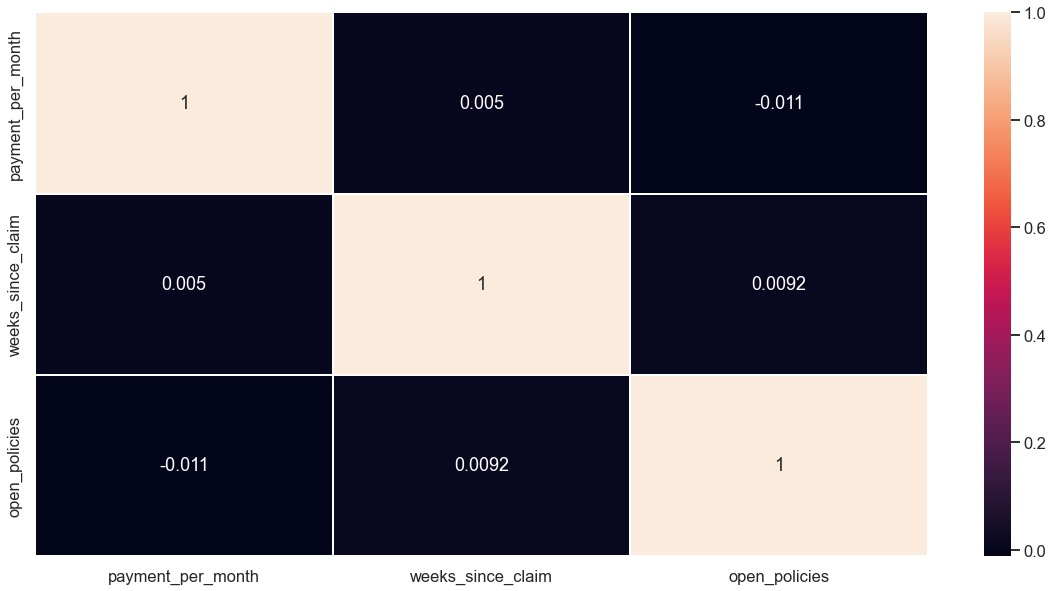

In [15]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=True,linewidths = 2)
plt.show()

### Categorical tests

In [16]:
type_plan_churn_ct=pd.crosstab(index=df['type_of_plan'],columns=df['churn'])
(chi2, p, dof,_) = stats.chi2_contingency([type_plan_churn_ct.iloc[0].values,type_plan_churn_ct.iloc[1].values,type_plan_churn_ct.iloc[2].values])
print ("chi2     : " ,chi2)
print ("p-value  : " ,p)
print ("Degree for Freedom : " ,dof)

chi2     :  0.06127654207787638
p-value  :  0.969826323902391
Degree for Freedom :  2


In [17]:
type_vehicle_churn_ct=pd.crosstab(index=df['type_of_vehicle'],columns=df['churn'])
(chi2, p, dof,_) = stats.chi2_contingency([type_vehicle_churn_ct.iloc[0].values,type_vehicle_churn_ct.iloc[1].values,type_vehicle_churn_ct.iloc[2].values,type_vehicle_churn_ct.iloc[3].values,type_vehicle_churn_ct.iloc[4].values,type_vehicle_churn_ct.iloc[5].values])
print ("chi2     : " ,chi2)
print ("p-value  : " ,p)
print ("Degree for Freedom : " ,dof)

chi2     :  21.210243375074025
p-value  :  0.0007392131130991751
Degree for Freedom :  5


In [18]:
offer_type_churn_ct=pd.crosstab(index=df['Renew_Offer_Type'],columns=df['churn'])
(chi2, p, dof,_) = stats.chi2_contingency([offer_type_churn_ct.iloc[0].values,offer_type_churn_ct.iloc[1].values,offer_type_churn_ct.iloc[2].values,offer_type_churn_ct.iloc[3].values])
print ("chi2     : " ,chi2)
print ("p-value  : " ,p)
print ("Degree for Freedom : " ,dof)

chi2     :  548.1644514293835
p-value  :  1.73695030654266e-118
Degree for Freedom :  3


### data preprocessing

In [19]:
cat_features=['city','type_of_plan','highest_level_education','work_status',
    'sex','relationship_status','reachability','type_of_vehicle','Renew_Offer_Type']

In [20]:
df_ohe=pd.get_dummies(df[cat_features])

In [21]:
df_num=df.drop(*[cat_features], axis=1)

In [22]:
df_new=pd.concat([df_ohe, df_num],axis=1)

In [23]:
df_new.head()

,city_Accra,city_Cape_coast,city_Kumasi,city_Takoradi,city_Tamale,type_of_plan_extended_plan,type_of_plan_premium_plan,type_of_plan_primary_plan,highest_level_education_Bachelor,highest_level_education_College,highest_level_education_Doctor,highest_level_education_High School or Below,highest_level_education_Master,work_status_Disabled,work_status_Employed,work_status_Medical Leave,work_status_Retired,work_status_Unemployed,sex_female,sex_male,relationship_status_Divorced,relationship_status_Married,relationship_status_Single,reachability_contacting_agent,reachability_contacting_branch_directly,reachability_customer_call_centre,reachability_via_the_web,type_of_vehicle_2-door_car,type_of_vehicle_4-door_car,type_of_vehicle_SUV,type_of_vehicle_Sports Car,type_of_vehicle_luxirious_car,type_of_vehicle_luxurious_suv,Renew_Offer_Type_1,Renew_Offer_Type_2,Renew_Offer_Type_3,Renew_Offer_Type_4,churn,payment_per_month,weeks_since_claim,open_policies
0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,No,138,138,1
1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,No,188,56,8
2,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,No,216,77,2
3,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,No,212,77,7
4,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,No,146,52,1


In [24]:
df_new['churn']=df_new['churn'].replace({'No':0,'Yes':1})

In [25]:
df_new['churn'].value_counts(normalize=True)

0    0.856799
1    0.143201
Name: churn, dtype: float64

In [26]:
X=df_new.drop(columns='churn')
y=df_new['churn']

### model training and evaluation

In [27]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y, test_size=0.2, random_state=0)

In [28]:
def evaluate_algorithms(X_train,y_train,X_valid,y_valid,model_predictions,model):
    print(f'The results from the {model}')
    print('---------------------')
    print('accuracy:',accuracy_score(model_predictions, y_valid))
    print('f1:',f1_score(model_predictions, y_valid,zero_division=1))
    print('recall:',recall_score(model_predictions, y_valid,zero_division=1))
    print('precision:',precision_score(model_predictions, y_valid,zero_division=1))
    sns.heatmap(confusion_matrix(model_predictions, y_valid),annot=True, annot_kws={"fontsize":20}, fmt='d', cbar=False,cmap='icefire')
    plt.title('Confusion Matrix', color='navy', fontsize=15)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values');

The results from the LogisticRegression(solver='liblinear')
---------------------
accuracy: 0.8653530377668309
f1: 0.21656050955414013
recall: 0.7727272727272727
precision: 0.1259259259259259


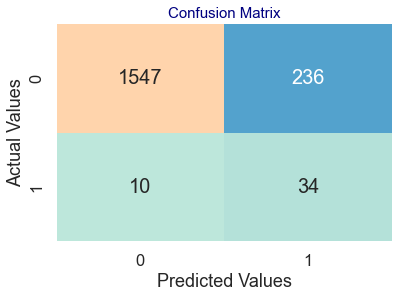

In [29]:
lr=LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)
model_predictions=lr.predict(X_valid)
evaluate_algorithms(X_train,y_train,X_valid,y_valid,model_predictions,model=lr)

The results from the XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
---------------------
accuracy: 0.9863163656267104
f1: 0.9537892791127541
recall: 0.9520295202952029
precision: 0.9555555555555556


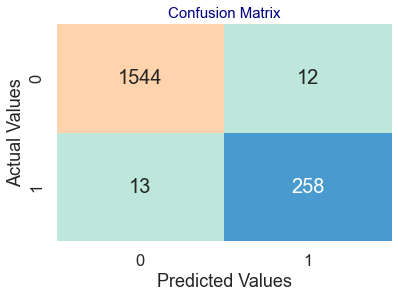

In [30]:
xg=XGBClassifier(random_state=0,verbosity=0)
xg.fit(X_train,y_train)
model_predictions=xg.predict(X_valid)
evaluate_algorithms(X_train,y_train,X_valid,y_valid,model_predictions,model=xg)

The results from the XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
---------------------
accuracy: 0.9852216748768473
f1: 0.9497206703910613
recall: 0.9550561797752809
precision: 0.9444444444444444


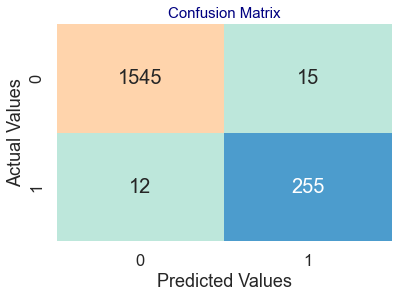

In [31]:
xg=XGBClassifier(random_state=0,verbosity=0)
xg.fit(X_train,y_train)
model_predictions = xg.predict_proba(X_valid)[:,1] >= 0.54
evaluate_algorithms(X_train,y_train,X_valid,y_valid,model_predictions,model=xg)

best parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100}
The results from the XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
---------------------
accuracy: 0.9874110563765737
f1: 0.9577981651376146
recall: 0.9490909090909091
precision: 0.9666666666666667


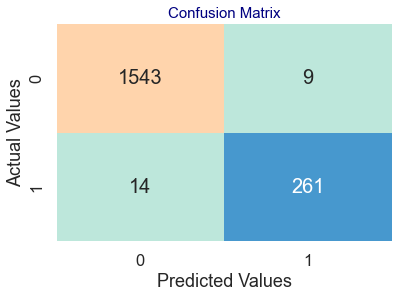

In [32]:
param_grid = { 
    'n_estimators': [50,70,100],
    'max_depth': [None,3,6,7],
    'learning_rate' : [0.03,0.3]
}
xg_hpo = XGBClassifier(random_state=0)
cv_xgb = GridSearchCV(estimator=xg_hpo, param_grid=param_grid, cv=5,verbose=0,n_jobs=-1)
cv_xgb.fit(X_train, y_train)
print('best parameters:',cv_xgb.best_params_)
model_predictions=cv_xgb.best_estimator_.predict(X_valid)
evaluate_algorithms(X_train,y_train,X_valid,y_valid,model_predictions,model=xg_hpo)

The results from the XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
---------------------
accuracy: 0.9901477832512315
f1: 0.9662921348314608
recall: 0.9772727272727273
precision: 0.9555555555555556


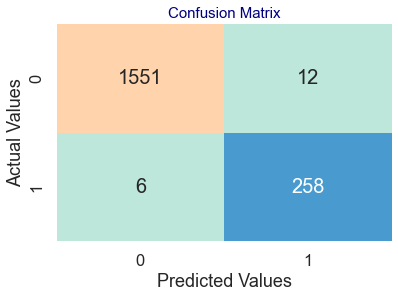

In [33]:
xg=XGBClassifier(learning_rate= 0.3, max_depth= 7, n_estimators= 100,random_state=0,verbosity=0)
xg.fit(X_train,y_train)
model_predictions = xg.predict_proba(X_valid)[:,1] >= 0.6
evaluate_algorithms(X_train,y_train,X_valid,y_valid,model_predictions,model=xg)

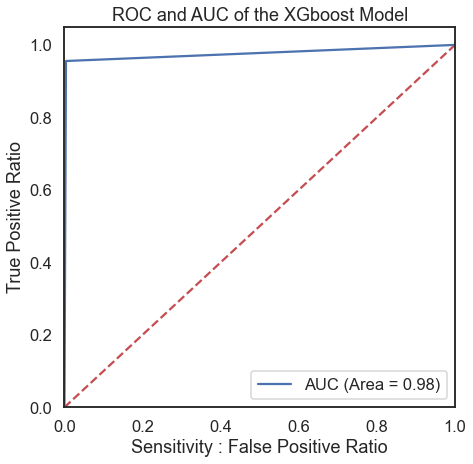

In [34]:
fpr, tpr, thresholds = roc_curve(y_valid, model_predictions)
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label='AUC (Area = %0.2f)' %roc_auc_score(y_valid, model_predictions))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Sensitivity : False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC and AUC of the XGboost Model')
plt.legend()
plt.show()

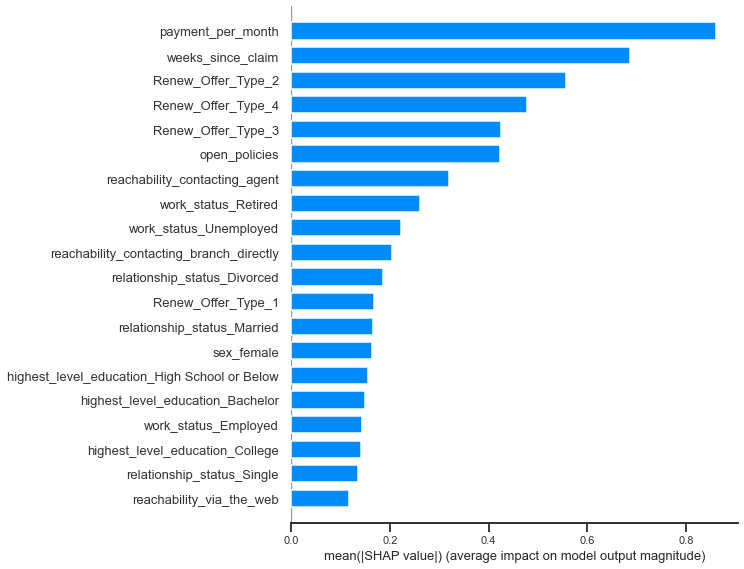

In [35]:
explainer = shap.TreeExplainer(cv_xgb.best_estimator_)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, plot_type="bar")